# MELANOMA DETECTION USING CNN MODELS.

# Problem Statement:

Develop a custom Convolutional Neural Network (CNN) in TensorFlow to accurately detect melanoma, a potentially fatal skin cancer that accounts for 75% of skin cancer-related deaths if not detected early. This model aims to analyze medical images and assist dermatologists by identifying the presence of melanoma, thereby reducing the manual effort required in diagnosis.

The dataset contains 2,357 images of both malignant and benign skin conditions, sourced from the International Skin Imaging Collaboration (ISIC). The images are categorized by type, with melanomas and moles slightly dominant in number. Each disease category is represented by an equal number of images, except for these two classes.

The dataset includes the following skin conditions:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

Using this data, the goal is to build a robust multiclass classification model to effectively differentiate between these nine distinct skin conditions.

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


# Data Reading/Data Understanding:

#### Defining the file paths for training and testing images.
#### 
This dataset includes approximately 2,357 images representing various skin cancer types, organized into nine subdirectories within both the training and testing folders. Each subdirectory contains images corresponding to one of the nine specific skin cancer types.

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("C:/Users/chira/OneDrive/Desktop/CP/UpGrad notes and documents/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("C:/Users/chira/OneDrive/Desktop/CP/UpGrad notes and documents/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [7]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


In [8]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split=0.2,image_size=(img_height,img_width),batch_size=batch_size,color_mode='rgb',subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split=0.2,image_size=(img_height,img_width),batch_size=batch_size,color_mode='rgb',subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,seed=123,image_size=(img_height,img_width),batch_size=batch_size,color_mode='rgb')

Found 118 files belonging to 9 classes.


In [12]:
# Listing out all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset visualisation:

#### Creating a code to visualize one instance of all the nine classes present in the dataset.

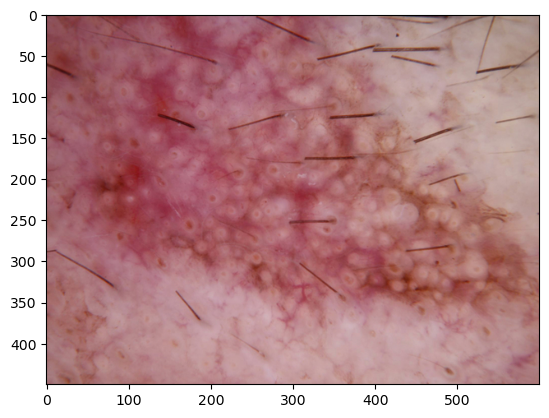

In [13]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

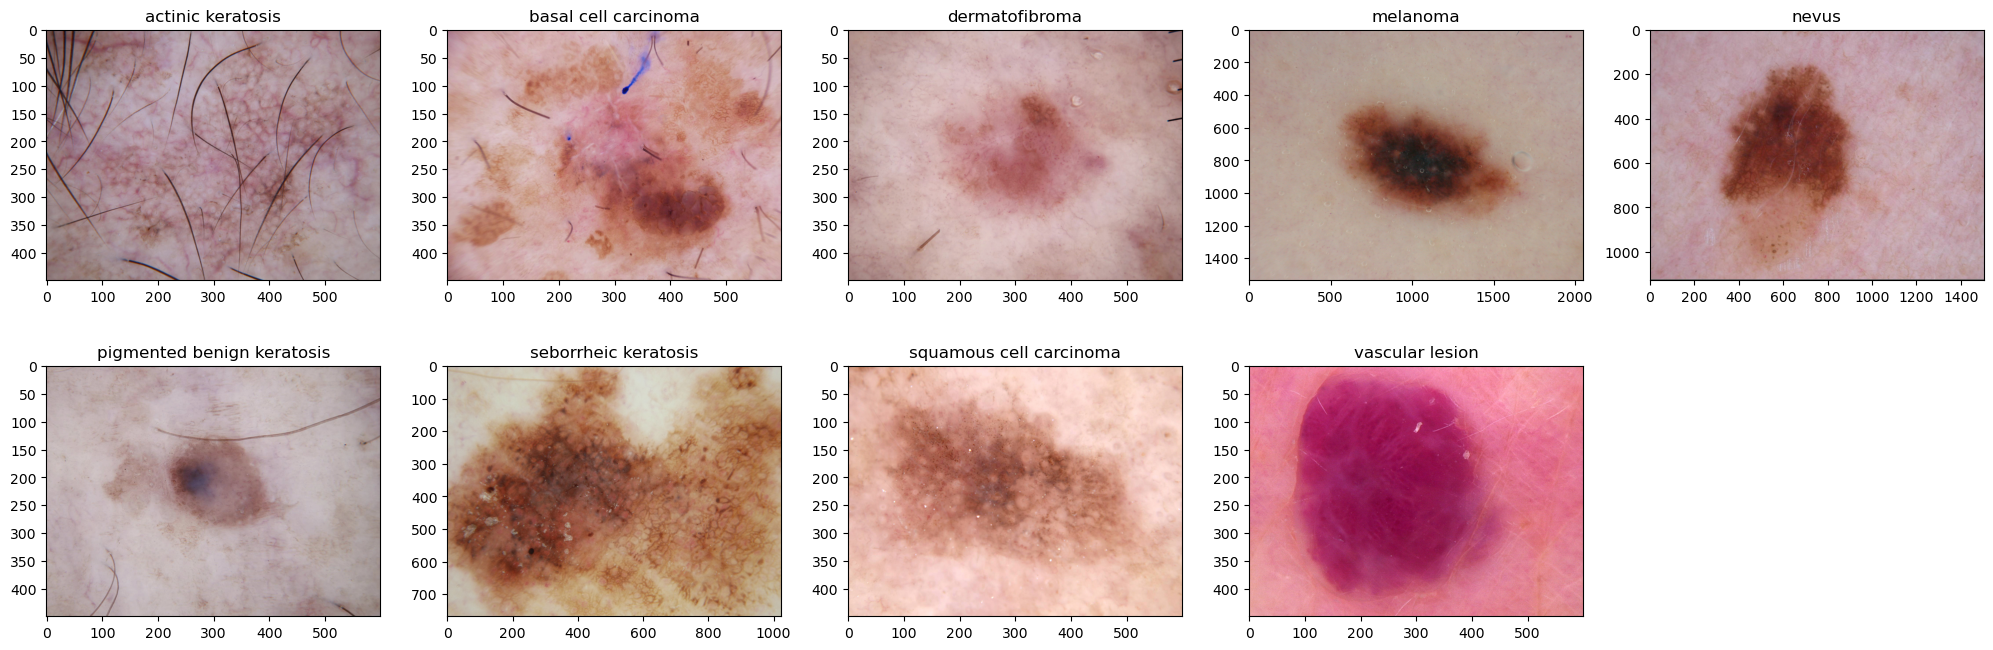

In [14]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [15]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.\
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Model Building & Training:

* Constructing a CNN model capable of accurately identifying the nine classes within the dataset, with image rescaling applied to normalize pixel values between 0 and 1.
* Selecting an appropriate optimizer and loss function for effective model training.
* Training the model over approximately 20 epochs.
* Visualizing performance metrics after training to assess for signs of overfitting or underfitting.

In [17]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [18]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.2202 - loss: 4.5258 - val_accuracy: 0.3781 - val_loss: 1.8040
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.3918 - loss: 1.7694 - val_accuracy: 0.4362 - val_loss: 1.5971
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4519 - loss: 1.6125 - val_accuracy: 0.5190 - val_loss: 1.4248
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5046 - loss: 1.4963 - val_accuracy: 0.4586 - val_loss: 1.5444
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5591 - loss: 1.2828 - val_accuracy: 0.4989 - val_loss: 1.4454
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5911 - loss: 1.1561 - val_accuracy: 0.5369 - val_loss: 1.4219
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6556 - loss: 0.9949 - val_accuracy: 0.4966 - val_loss: 1.5529
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6725 - loss: 0.9719 - val_accuracy: 0.4810 - val_loss:

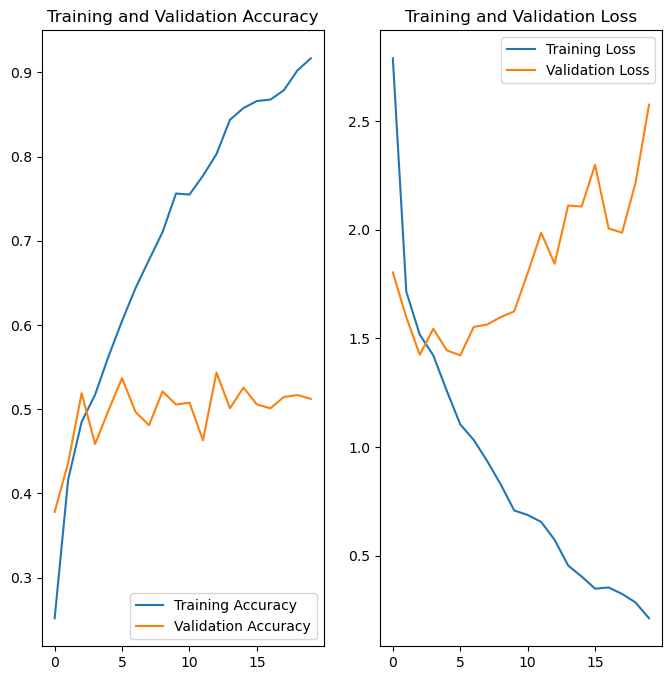

In [20]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

# FINDINGS:

#### While training accuracy increases steadily over time, validation accuracy plateaus at around 50% during the training process. Additionally, although training loss decreases with each epoch, validation loss begins to rise. 
#### The plots reveal a significant gap between training and validation accuracy, with the model reaching only about 50% accuracy on the validation set. This noticeable difference in accuracy is indicative of overfitting.

# Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

#### Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

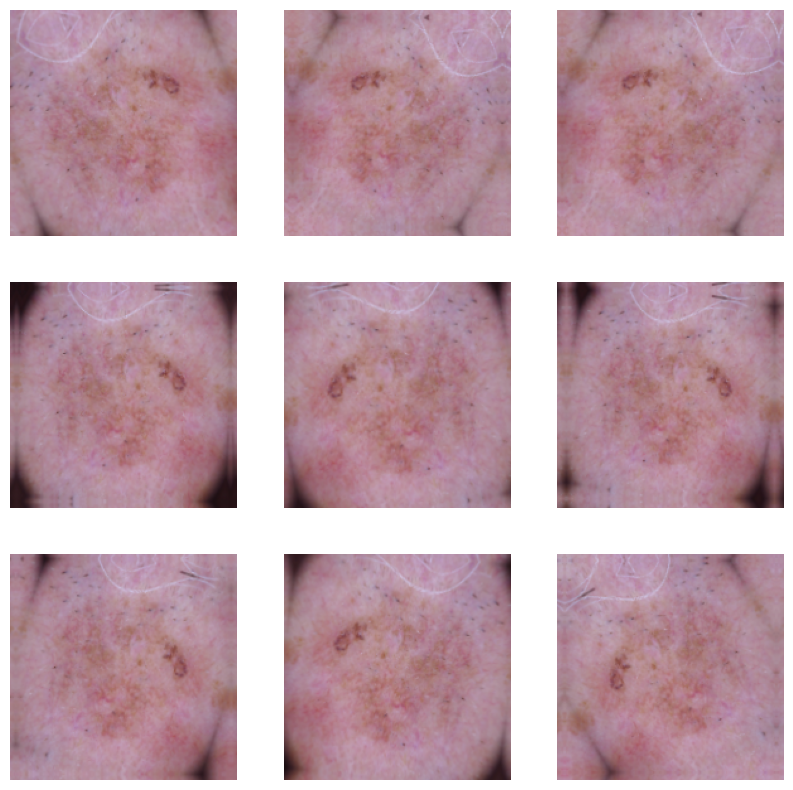

In [22]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building & training on the augmented data :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [23]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [24]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.1946 - loss: 5.1499 - val_accuracy: 0.3154 - val_loss: 1.8039
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.3226 - loss: 1.8081 - val_accuracy: 0.4452 - val_loss: 1.5893
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.4692 - loss: 1.5426 - val_accuracy: 0.4989 - val_loss: 1.4554
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5031 - loss: 1.4215 - val_accuracy: 0.5436 - val_loss: 1.4177
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5067 - loss: 1.3696 - val_accuracy: 0.4698 - val_loss: 1.5663
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5166 - loss: 1.4028 - val_accuracy: 0.5235 - val_loss: 1.4694
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5367 - loss: 1.3163 - val_accuracy: 0.5414 - val_loss: 1.3530
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5275 - loss: 1.3194 - val_accuracy: 0.5391 - val_loss:

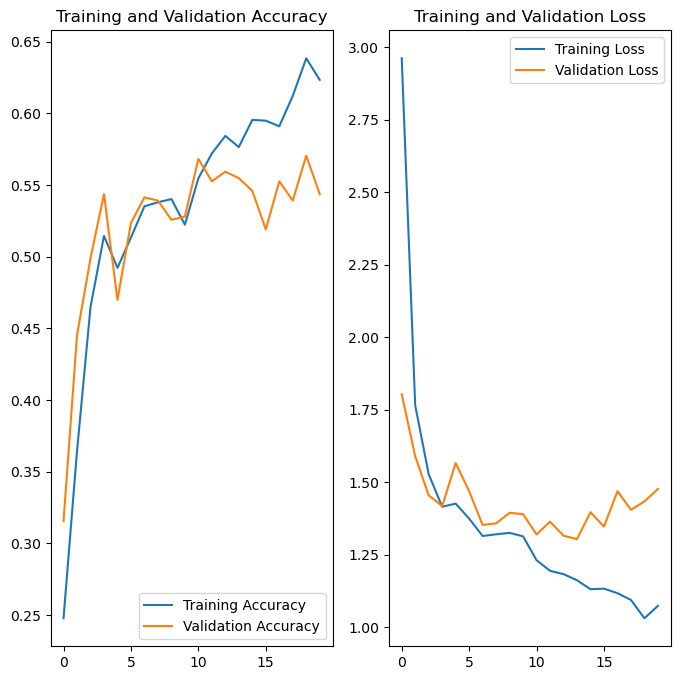

In [26]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

## FINDINGS:

#### As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
#### As the training loss decreases with epochs the validation loss decreases and stalls.
#### The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
#### The difference in accuracy between training and validation accuracy is still slightly noticeable which is a sign of overfitting.
   

# Model Building & training on the augmented data with dropout :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [27]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [28]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.1814 - loss: 10.3779 - val_accuracy: 0.2752 - val_loss: 1.9398
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3562 - loss: 1.7993 - val_accuracy: 0.4743 - val_loss: 1.5884
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4751 - loss: 1.5082 - val_accuracy: 0.5123 - val_loss: 1.4450
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4766 - loss: 1.4834 - val_accuracy: 0.3826 - val_loss: 1.7229
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4622 - loss: 1.4639 - val_accuracy: 0.5213 - val_loss: 1.4146
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5181 - loss: 1.3772 - val_accuracy: 0.5302 - val_loss: 1.4207
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5245 - loss: 1.3287 - val_accuracy: 0.4944 - val_loss: 1.4759
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5516 - loss: 1.3006 - val_accuracy: 0.4877 - val_loss

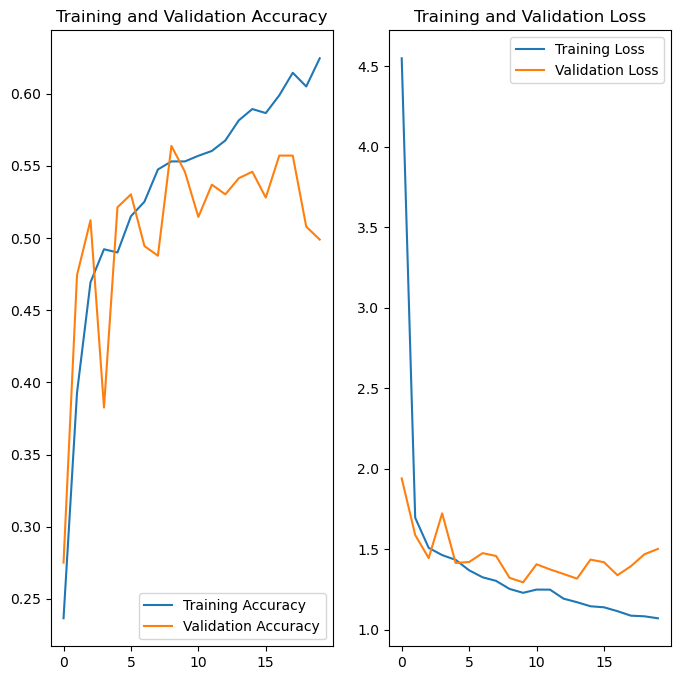

In [30]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

## FINDINGS:

#### As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
#### As the training loss decreases with epochs the validation loss decreases.
#### The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
#### The difference in accuracy between training and validation accuracy is very less.

## It is observed that the overfitting of the model is reduced significantly when compared the earlier models.

# Class distribution:

#### Examining the current class distribution in the training dataset

#### Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

#### Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


## FINDINGS:
    
### Which class has the least number of samples?
* seborrheic keratosis with 77 samples.
### Which classes dominate the data in terms proportionate number of samples?
* pigmented benign keratosis with 462 samples.


# Handling class imbalances:

#### Rectifing class imbalances present in the training dataset with Augmentor library.

In [32]:
!pip install Augmentor

In [33]:
#import shutil
#shutil.rmtree("/kaggle/working/")

In [34]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory="/content/melanoma/"+i+"/")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

OSError: The source directory you specified does not exist.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
data_dir_train = pathlib.Path("/content/melanoma/")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data:

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [ ]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [ ]:
df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [ ]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Model Building & training on the rectified class imbalance data :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [ ]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

In [ ]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

## FINDINGS:

#### As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.
#### As the training loss decreases with epochs the validation loss also decreases.
#### The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 77% accuracy on the validation set.
#### The difference in accuracy between training and validation accuracy is very less.
#### Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 80%